In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv,
                                     inner, perturb_inv, clr, clr_inv, centralize)
from skbio import TreeNode, DistanceMatrix
from gneiss import ols
from gneiss.sort import mean_niche_estimator, niche_sort
from gneiss.util import match
from gneiss.balances import balance_basis

from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
import seaborn as sns
from biom import load_table

from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean

%matplotlib inline

/Users/mortonjt/miniconda3/envs/gneiss/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mortonjt/miniconda3/envs/gneiss/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
mapping = pd.read_table('data/88soils/103_prep_568_qiime_20150818-225427.txt', index_col=0)
table = load_table('data/88soils/238_otu_table.biom')

Now we will be filtering out OTUs that are lower abundance.  We'll set the threshold to be 100 reads.
This is because there is going to be a lot of garbage OTUs due to contamination, sequencing error, or clustering errors.  We feel that the 100 read filter is conservative enough to demonstrate the utility of this tool.

In [3]:
read_filter = lambda val, id_, md: sum(val) > 100
table.filter(read_filter, axis='sample') 
table.filter(read_filter, axis='observation')

116 x 88 <class 'biom.table.Table'> with 3411 nonzero entries (33% dense)

We'll want to convert the biom object into a pandas dataframe for easier manipulation.

In [4]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

One thing to note is that the OTU table and the metadata file may not be in the same order.
It is incredibly important to make sure that the samples are in the same order.  We have defined a function in `gneiss`
called [`match`](https://github.com/biocore/gneiss/blob/master/gneiss/util.py#L11) explicitly designed to handle this issue.

In [5]:
otu_table, taxonomy = convert_biom_to_pandas(table)
otu_table, mapping = match(otu_table, mapping)

Now that we have the tables ordered properly, we'll want to build a tree. We'll want to build the tree based on 
pH information of the individual bacteria.  To do so, we'll first calculate the mean pH that each bacteria prefer to 
live in using [`mean_niche_estimator`](https://github.com/biocore/gneiss/blob/master/gneiss/sort.py#L14)

We can calculate distances between bacteria using the difference in their mean pH values.  A distance matrix of these distances can be used to build a bifurcating tree using hierarchical clusing using the [`average`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.average.html#scipy.cluster.hierarchy.average)

In [6]:
mean_ph = mean_niche_estimator(otu_table, gradient=mapping.ph)
dm = DistanceMatrix.from_iterable(mean_ph, euclidean)
lm = average(dm.condensed_form()) 
ph_tree = TreeNode.from_linkage_matrix(lm, otu_table.columns) 

We'll want to fit a quartic linear model to each of the balances individually with respect to pH.  For now, we'll
define 3 more variables encoding different powers of pH as follows.

In [7]:
mapping['ph2'] = mapping.ph ** 2
mapping['ph3'] = mapping.ph ** 3
mapping['ph4'] = mapping.ph ** 4

Now we can run the linear regression using [`ols`](https://github.com/biocore/gneiss/blob/master/gneiss/_formula.py#L97).  All of the covariates (i.e. `ph`, `ph2`, `ph3`, `ph4`) can be encoded in the regression model.  Note that there is no dependent variable defined, since this regression is run individually against all of the balances specified by `otu_table` and `ph_tree`

In [8]:
res = ols('ph + ph2 + ph3 + ph4', otu_table + 1, mapping, ph_tree) 

Finally, we'll want to sort both the rows and columns the original table according to the pH gradient.  We've defined
the function [`niche_sort`](https://github.com/biocore/gneiss/blob/master/gneiss/sort.py#L67) to handle this.

In [9]:
observed_table = niche_sort(otu_table, mapping.ph)

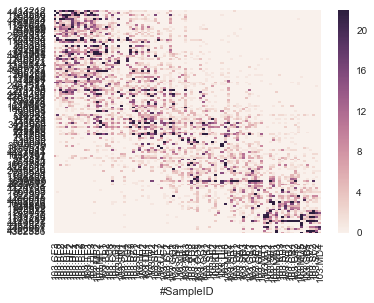

In [10]:
sns.heatmap(observed_table.T, robust=True)

For comparison, we'll want to visualize the predicted microbial proportions.  Note the `project=True` parameter allows 
the predictions to be returned as proportions, rather than as balances.

In [11]:
predicted_table = res.predict(project=True)
predicted_table = predicted_table.reindex(index=observed_table.index, 
                                          columns=observed_table.columns)

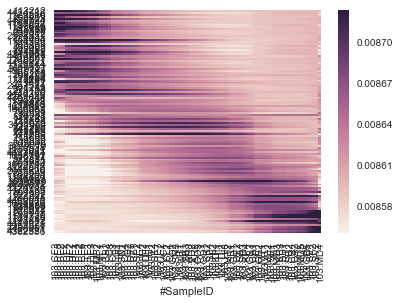

In [12]:
sns.heatmap(predicted_table.T, robust=True)